In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams

from scipy.stats import boxcox
rcParams['figure.figsize']=10,6

In [2]:
df= pd.read_csv('Electric_Production.csv', encoding='gbk',parse_dates=['DATE'],infer_datetime_format=True)
#index the dataet using date
indf=df.set_index(['DATE'])

In [3]:
indf.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
indf.rename(columns={'IPG2211A2N':'value'},inplace=True)
indf.head()

,value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


##### Visualise the dataset

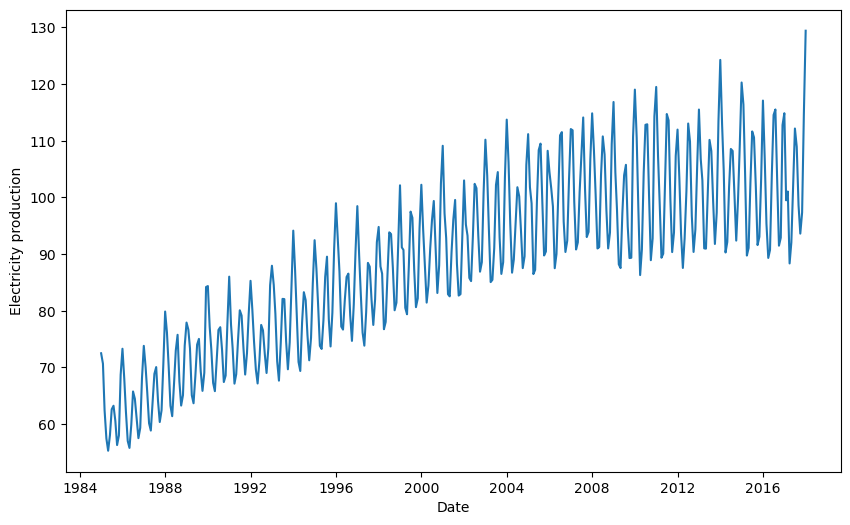

In [5]:
plt.xlabel('Date')
plt.ylabel('Electricity production')
plt.plot(indf)

##### Decompose the time series

In [6]:
def decompose(timeseries):
    timeseries.dropna(inplace=True)
    decomposition=seasonal_decompose(timeseries)
    trend=decomposition.trend
    seasonal=decomposition.seasonal
    residual=decomposition.resid

    #create subplots for the data visualization
    fig, (ax1, ax2,ax3, ax4) =plt.subplots (4, sharex=True, constrained_layout=False)
    ax1. set_title (" Visualizations for Timeseries,Trend, Seasonality and Resudials" )

    l1, =ax1.plot(timeseries,color='blue')

    l2, =ax2.plot(trend,color='red')

    l3, =ax3.plot(seasonal,color='green')

    l4, =ax4.plot(residual,color='blue')
    labels=['Time series','Tremd','Seasonality', 'Residuals']

    fig.legend(labels=labels, loc= 'lower center', ncol=5)
    plt.show()

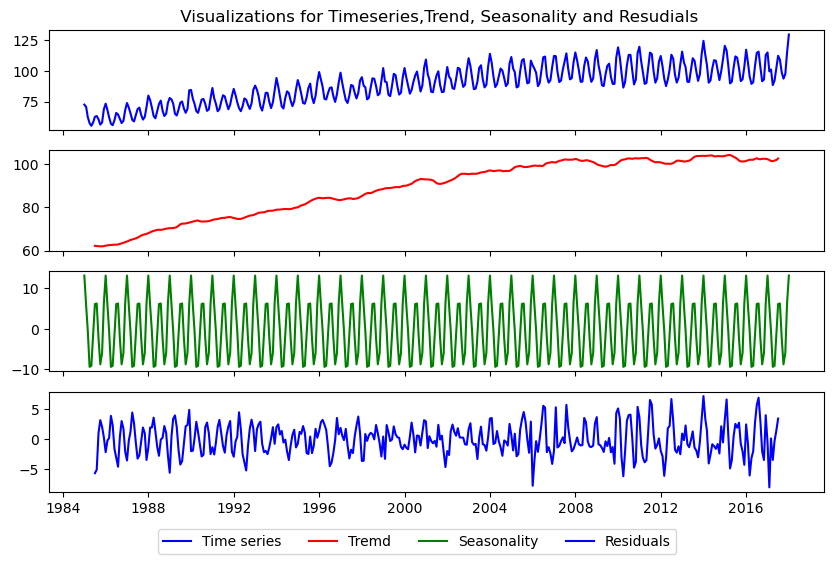

In [7]:
decompose(indf)

##### Rolling statistics

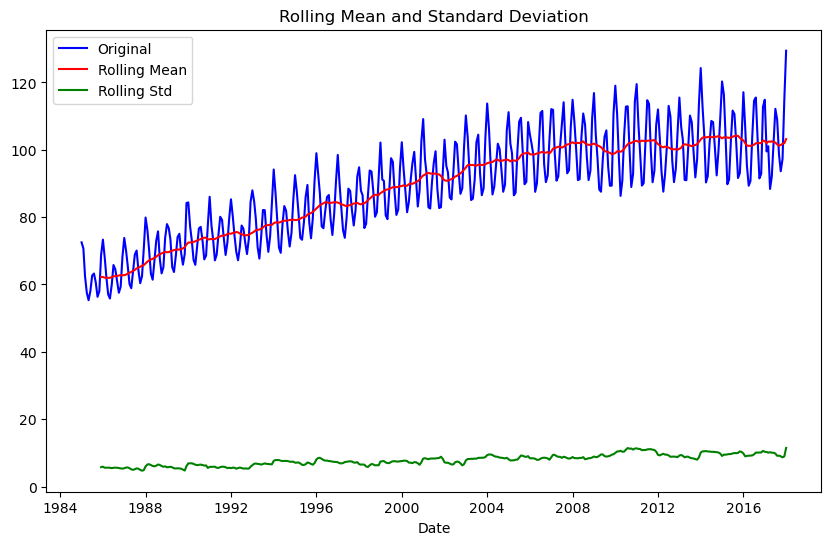

In [8]:
#Determine rolling statistics
rolmean=indf.rolling(window=12).mean()
rolstd=indf.rolling(window=12).std()

#plot rolling statistics
orig=plt.plot(indf,color='blue',label='Original')
aveg=plt.plot(rolmean,color='red',label='Rolling Mean')
std=plt.plot(rolstd,color='green',label='Rolling Std')
plt.legend(loc='best')
plt.xlabel('Date')
plt.title("Rolling Mean and Standard Deviation")
plt.show()

Perform Arguemented Dicker Fuller Test The test is used to determine whether the timeseries is stationary or not if p-value is greater than 0.5, the timeseries is not stationary

In [9]:
#Perform argumented Dicker Fuller Test
def adft(timeseries):
    print('Results of ADFT')
    adftest=adfuller(timeseries['value'],autolag='AIC')
    dfout=pd.Series(adftest[0:4],index=['Test Statistic','P-value','#Lags Used','Number of Observations used'])
    for key, value in adftest[4].items():
        dfout['Critical Value (%s)' %key]=value
    print(dfout)
adft(indf)

Results of ADFT
Test Statistic                  -2.256990
P-value                          0.186215
#Lags Used                      15.000000
Number of Observations used    381.000000
Critical Value (1%)             -3.447631
Critical Value (5%)             -2.869156
Critical Value (10%)            -2.570827
dtype: float64


The p-Value is greater than 0.5 , thus the timeseries is not stationary. Therefore, we'll have to remove the trend and seasonality.

##### Detrend the Time Series
There are several tools used to remove trend from a time series In this case, we will use log transformation and moving average.

In [10]:
#remove trend using moving average on log transformed time-series
#1. log transform the timeseries
indf_lgs= indf
indf_lgs['value']=boxcox(indf_lgs['value'], lmbda=0.0)
#2. compute moving average on logged data
mAvg= indf_lgs.rolling(window=12).mean()
#3.subtract moving average from the log  transformed time series, to detrend the series
indf_dt=indf_lgs-mAvg
indf_dt.dropna(inplace=True)

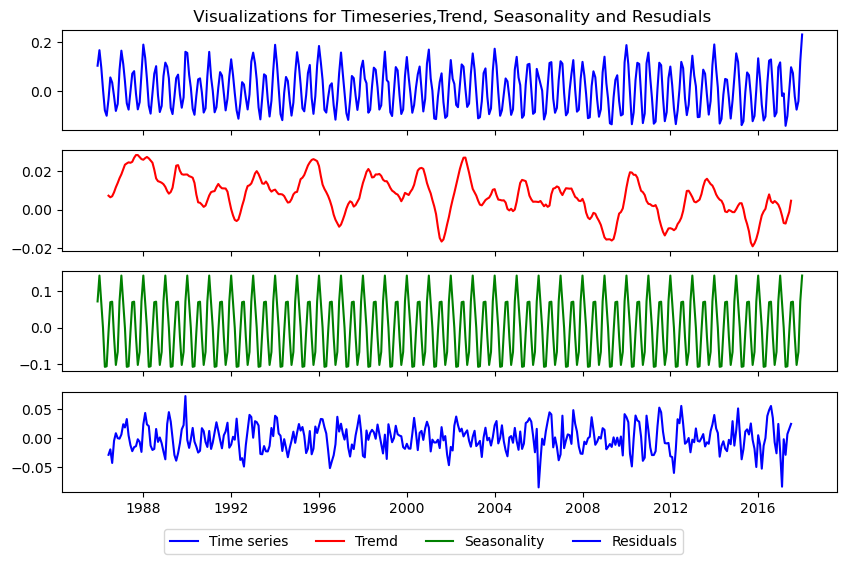

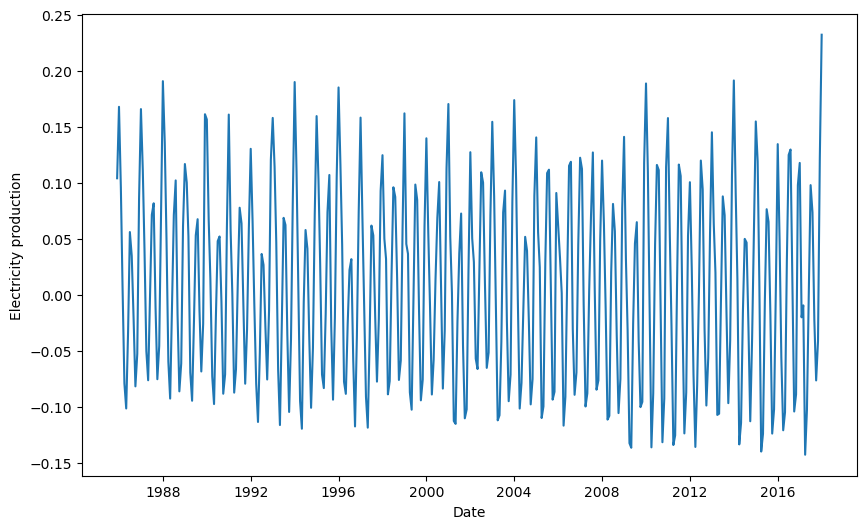

In [11]:
#decompose the timeseries after detrending
decompose(indf_dt)
# visualize timeseries after detrending
plt.xlabel('Date')
plt.ylabel('Electricity production')
plt.plot(indf_dt)

The trend has been removed and is no longer an uptrend in the decomposed visualizations

##### Remove seasonality from the Time Series

The next task is to remove seasonality from the time series The seasonality is removed using exponential decay transformation.

In [12]:
#remove seasonality using exponential decay transformation
indf_et=indf_dt.ewm(halflife=12, min_periods=0, adjust=True).mean()
indf_rs=indf_dt-indf_et
indf_rs.dropna(inplace=True)

In [13]:
#perform ADF test once more
adft(indf_rs)

Results of ADFT
Test Statistic                -7.213160e+00
P-value                        2.207771e-10
#Lags Used                     1.400000e+01
Number of Observations used    3.710000e+02
Critical Value (1%)           -3.448100e+00
Critical Value (5%)           -2.869362e+00
Critical Value (10%)          -2.570937e+00
dtype: float64


Now our P-Value is less than 0.5, we can ascertain that the time series is stationary.

##### Plot Autocorrelation Function and Partical Autocorrelation Funcitons
The plots will help us to find the values of p, and q. P and Q values determine the order of ARIMA model.

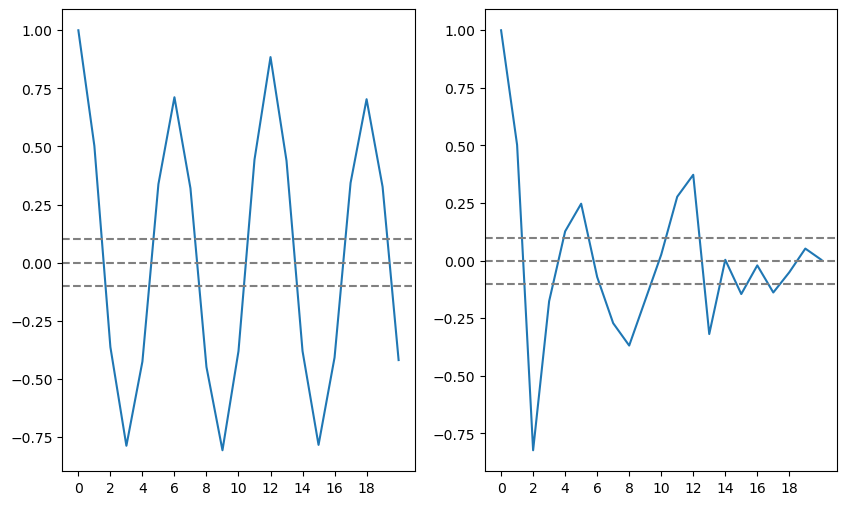

In [14]:
#plot ACF and PACF
lag_acf=acf(indf_rs,nlags=20)
lag_pacf=pacf(indf_rs, nlags=20,method='ywm')

#plot ACF
plt.subplot (121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indf_rs)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indf_rs)), linestyle='--',color='gray')
plt.xticks(range(0,20,2))

#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(indf_rs)), linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(indf_rs)), linestyle='--',color='gray')

plt.xticks(range(0,20,2))
plt.show()


From the graphs, the values of P and Q are approximately 2,2 respectivley. The values are obtained by reading the value of x,when y is zero.

##### Build the ARIMA Model

In [15]:
# split the dataset into train and test
ar_val=indf_rs.values
train=ar_val[1:len(ar_val)-10]
test=ar_val[len(ar_val)-10:]

In [16]:
#run the model
model=ARIMA(train, order=(2,1,2))
model=model.fit(method_kwargs={'warn_convergence':False})
pred=model.predict(start=len(train),end=len(train)+len(test)-1, dynamic= False)
ar_score=mean_squared_error(test, pred)
print('AR MSE: {}'.format(round(ar_score,4)))

AR MSE: 0.0019


The model has a Mean Squared Error of 0.0019. A smaller value shows that the predicted value are closer to the actual values. Better models have small MSE

#####  Plot between the Predicted Value and Actual Values

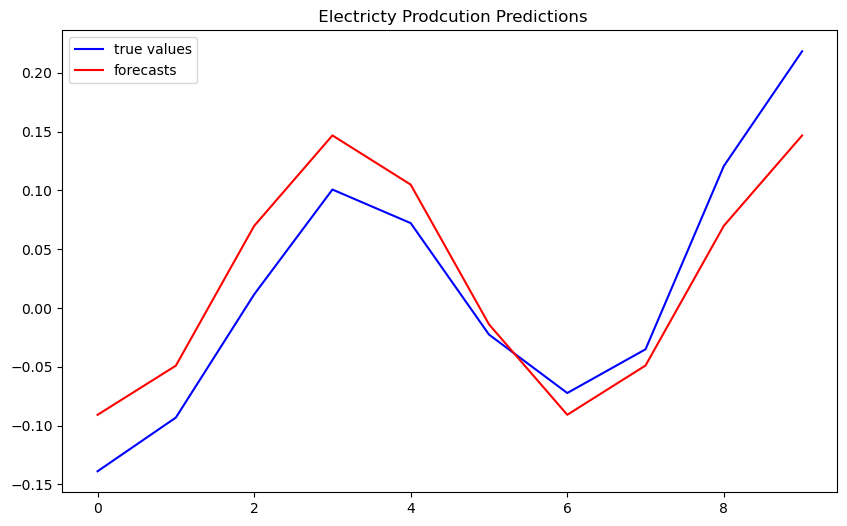

In [17]:
plt.plot(test,label='true values',color='blue')
plt.plot (pred, label='forecasts',color='red')
plt. title(' Electricty Prodcution Predictions')
plt.legend(loc='best')